# Union evaluations
In this notebook, we will evaluate the Jaccard similarity of the different methods. The first will be the implementation as provided from this Rust crate HyperLogLog couters, testing all of the available bits and precisions. Note that, since there are no Python bindings for the Rust crate (yet) we run the cose as one of the test in the crate test suite. 

The second one will be MinHash, using the implementation provided by the datasketch library. We will compare the performance of the two methods for the same amount of memory used.

## What is an HyperLogLog counter?
An HyperLogLog counter is a probabilistic data structure used to estimate the cardinality of a set. It is based on the observation that the cardinality of a set can be estimated by the maximum number of leading zeros in the binary representation of the hashes of the elements of the set. The HyperLogLog counter is a data structure that stores the maximum number of leading zeros for a set of hashes. The counter is initialized with a number of bits, which determines the maximum number of leading zeros that can be stored. The counter is then updated with the hashes of the elements of the set. The estimate of the cardinality is then given by the harmonic mean of the values stored in the counter. HyperLogLog counters can be used to compute the cardinality of the union of two sets by taking the maximum of the values stored in the two counters, and therefore we can also compute the Jaccard similarity of two sets.


In [1]:
import pandas as pd
df = pd.read_csv("union_cardinality_benchmark.tsv", sep="\t")
df["memory"] = 2**df.precision * df.bits
df

,precision,bits,exact,old,recent,hash_name,memory
0,4,1,44199,18.064531,18.064531,siphasher::sip::SipHasher13,16
1,4,2,44199,86.144000,86.144000,siphasher::sip::SipHasher13,32
2,4,3,44199,1378.304000,1378.304000,siphasher::sip::SipHasher13,48
3,4,4,44199,31895.666000,31895.666000,siphasher::sip::SipHasher13,64
4,4,5,44199,31895.666000,31895.666000,siphasher::sip::SipHasher13,80
...,...,...,...,...,...,...,...
167995,17,2,29069,29055.014000,29055.014000,siphasher::sip::SipHasher13,262144
167996,17,3,29069,29055.014000,29055.014000,siphasher::sip::SipHasher13,393216
167997,17,4,29069,29055.014000,29055.014000,siphasher::sip::SipHasher13,524288
167998,17,5,29069,29055.014000,29055.014000,siphasher::sip::SipHasher13,655360


In [2]:
from glob import glob
import pandas as pd
from tqdm.auto import tqdm

df = pd.concat([
    pd.read_csv(path, sep="\t")
    for path in tqdm(glob("union_test/*.tsv.gz"))
])

df["memory"] = 2**df.precision * df.bits
df

  0%|          | 0/100000 [00:00<?, ?it/s]

,precision,bits,exact,hll,nn,memory
0,8,6,397062,426806.470,391157.78,1536
0,8,6,450075,478586.780,436966.63,1536
0,8,6,105663,119218.484,108914.68,1536
0,8,6,346393,366406.220,336592.90,1536
0,8,6,265464,283791.660,259825.06,1536
...,...,...,...,...,...,...
0,8,6,370409,394773.470,360504.88,1536
0,8,6,308056,305078.840,279168.88,1536
0,8,6,331971,367946.720,337073.16,1536
0,8,6,320244,333806.600,304779.56,1536


In [3]:
import numpy as np

df["mse_hll"] = (df.exact - df.hll)**2
df["mse_nn"] = (df.exact - df.nn)**2
df["mse_rates"] = np.log((df.exact - df.nn)**2 / (df.exact - df.hll)**2)

(df["mse_rates"] > 1.0).mean()

0.13306

<Axes: >

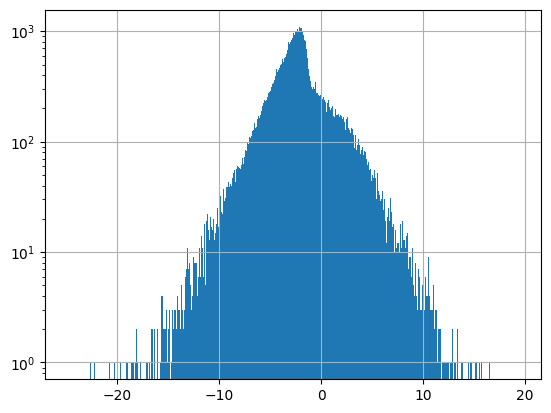

In [4]:
import matplotlib.pyplot as plt
df.mse_rates.hist(log=True, bins=1000)
#plt.xscale("log")

We determine the number of u64 words to use for the MinHash to execute versions of MinHash with comparable memory usage to the HyperLogLog counters.

In [6]:
import math

bits = df.bits.unique()
precision = df.precision.unique()

number_of_words = {
    # We divide again by 2 because the number of permutations used is a u64
    # and by two again as 
    math.ceil(b * 2**p / 32) // 2 // 2
    for b in bits
    for p in precision
}

# Some HyperLogLog counters require less than 64 bits, so there will be
# values in the list that are zero. We remove them.
number_of_words = [
    word
    for word in number_of_words
    if word > 0
]

We parallelize the computation of the Jaccard similarity using MinHash, which is significantly slower than the HyperLogLog counters as while the former is an extensively optimized Rust implementation, the latter is more didactical Python implementation.

In [7]:
df["old_squared_error"] = (df.exact - df.hll)**2
df["recent_squared_error"] = (df.exact - df.nn)**2
#df["bounded_squared_error"] = (df.exact - df.bounded_approximation)**2
columns = [
    "old_squared_error",
    "recent_squared_error",
    #"bounded_squared_error"
]
data_hll = df.groupby(["precision", "bits", "memory",])[columns].agg(["mean", "std"])
data_hll = data_hll.reset_index()
data_hll

precision bits memory old_squared_error               recent_squared_error  \
                                     mean           std                 mean   
0         8    6   1536      1.961102e+09  2.419204e+09         3.716497e+08   

                 
            std  
0  6.508915e+08

In [8]:
data_hll.recent_squared_error["mean"] / data_hll.old_squared_error["mean"]

0    0.189511
Name: mean, dtype: float64

We visualize two versions of the HyperLogLog counters, one including also **EXTREMELY SMALL** registers of 1 and 2 bits, which really push the limits of the HyperLogLog counters, and one without them, which is more representative of the performance of the HyperLogLog counters for the more common use cases. We include these tiny registers as exploring the limits of the HyperLogLog counters is one of the main goals of this project.

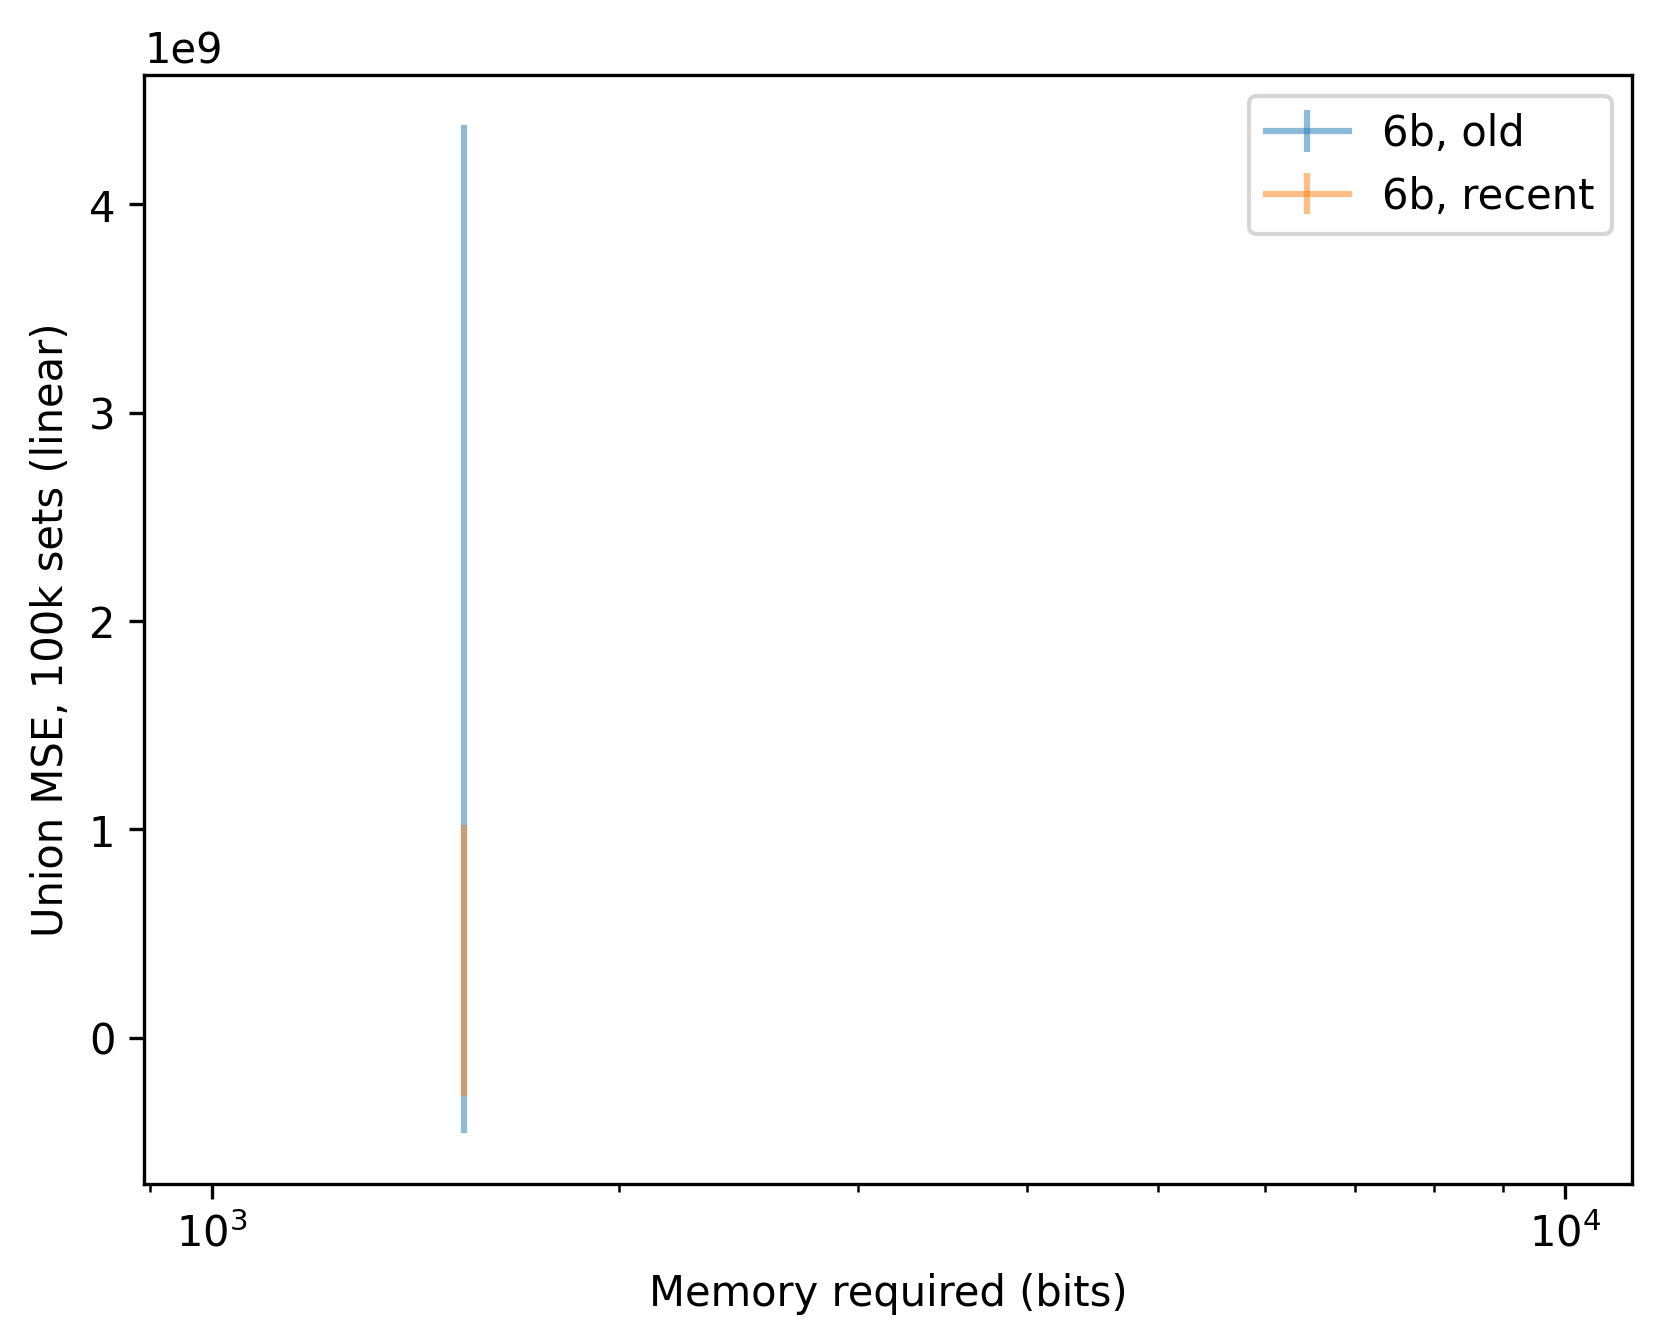

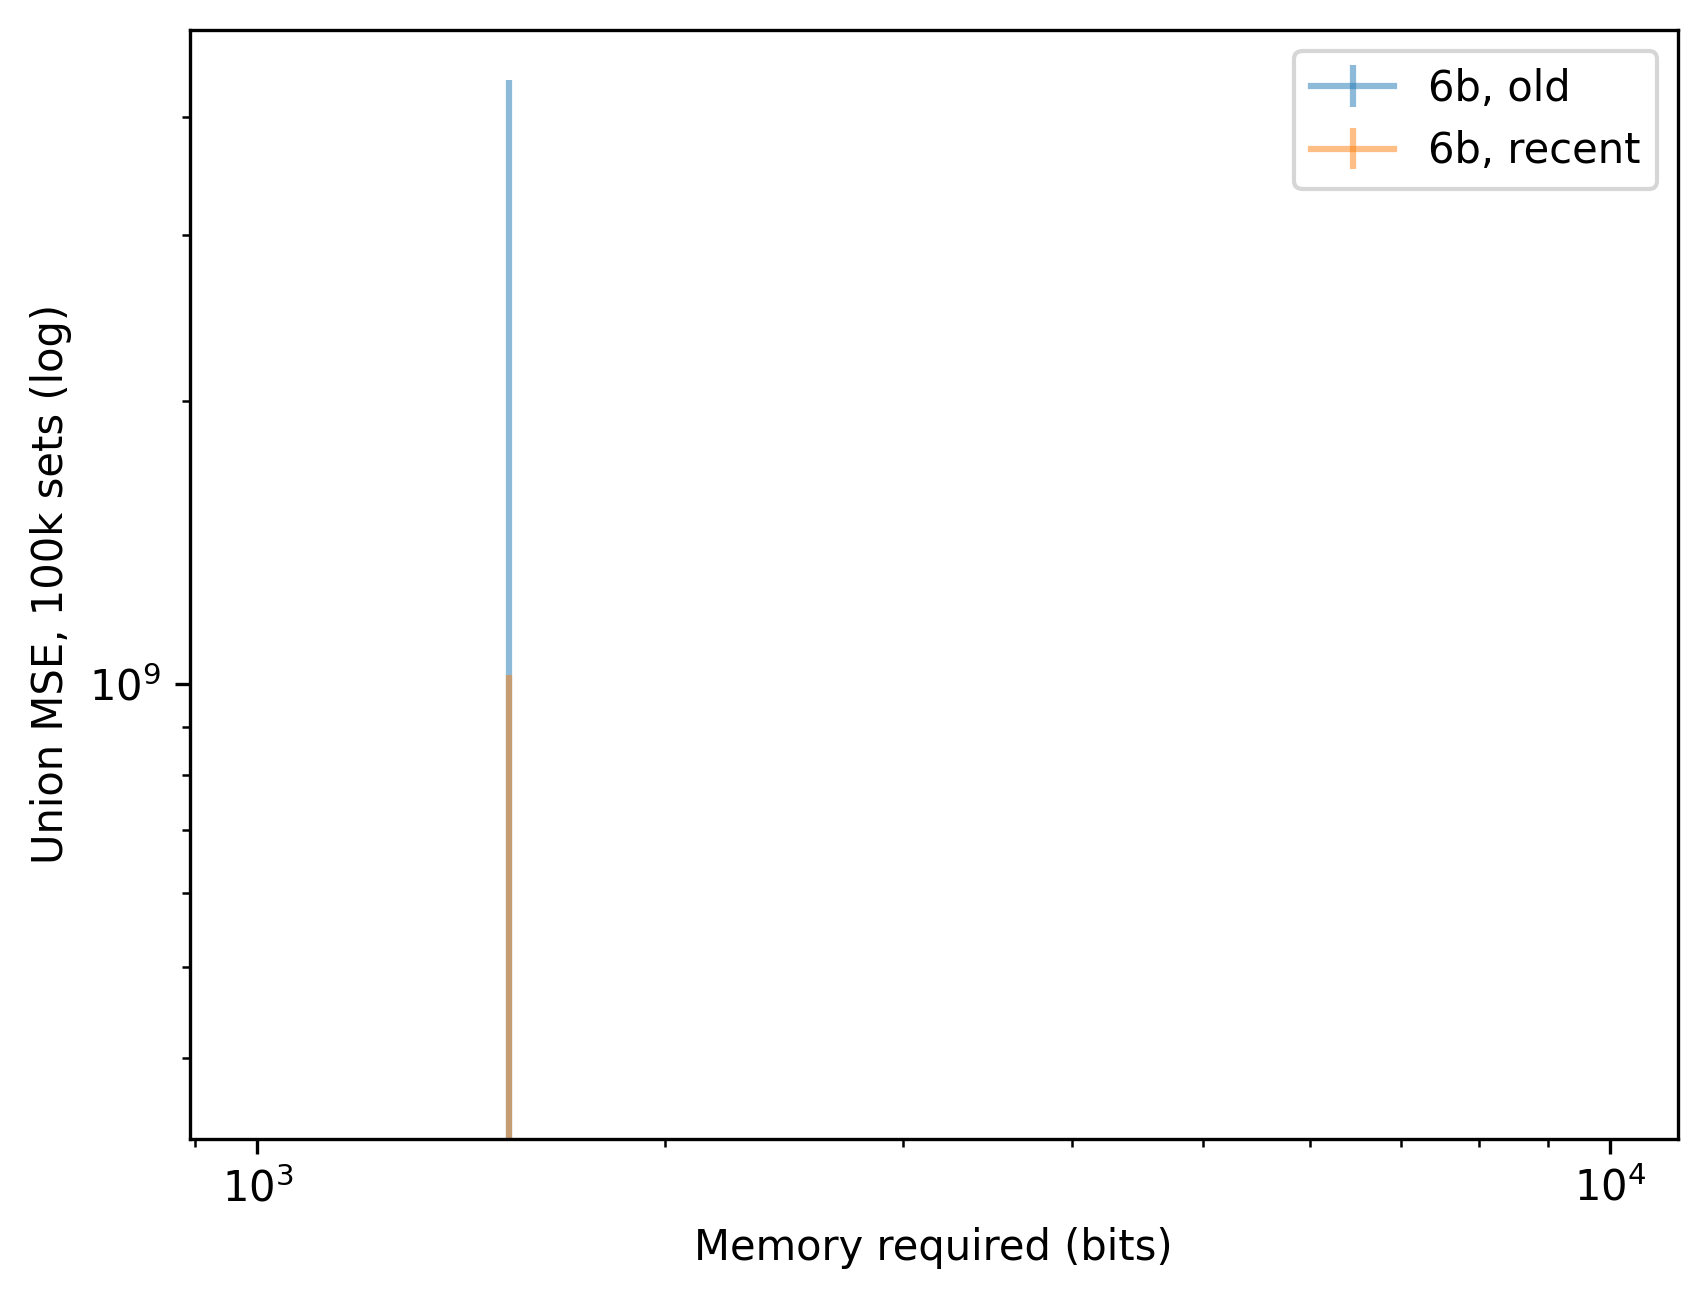

In [9]:
import matplotlib.pyplot as plt

bits_to_discard = (1, 2, 3, 4, 5)

hash_name_line_style = {
    "Hasher64_1": "-",
    "MetroHasher": "-",
    "SipHasher13": "--",
    "SipHasher24": "-.",
    "HighwayHasher": ":",
}

hash_name_marker_style = {
    "Hasher64_1": "o",
    "MetroHasher": "o",
    "SipHasher13": "^",
    "SipHasher24": "s",
    "HighwayHasher": "x",
}

for yscale in ("linear", "log"):
    fig, axes = plt.subplots(dpi=300)
    for bits in data_hll["bits"].unique():
        if bits in bits_to_discard:
            continue
        for column in columns:
            filtered = data_hll[data_hll.bits == bits]

            plt.errorbar(
                filtered.memory,
                filtered[column]["mean"],
                filtered[column]["std"],
                alpha=0.5,
                label=f"{bits}b, {column.split('_')[0]}"
            )
    plt.legend()
    plt.xscale("log")
    plt.yscale(yscale)
    plt.ylabel(f"Union MSE, 100k sets ({yscale})")
    plt.xlabel("Memory required (bits)")
    plt.show()